In [1]:
# !pip install scipy matplotlib statsmodels sklearn seaborn

## Forecasting Cryptocurrency returns with Twitter sentiment
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/other-industries/twitter/main.ipynb)._]

In this notebook, we attempt to forecast the cryptocurrency prices with [sentiment](https://en.wikipedia.org/wiki/Sentiment_analysis#:~:text=Sentiment%20analysis%20(also%20known%20as,affective%20states%20and%20subjective%20information.) from [Twitter](https://twitter.com/home?lang=en), alongside with some other Tweet metrics.  
The data used in this notebook is mined using the below notebooks:
- [Tweets mining](01_tweets_mining.ipynb)
- [Tweet sentiment](02_sentiment.ipynb)
- [Cryptocurrency mining](03_cryptocurrency_mining.ipynb)

For the given list of popular cryptocurrencies, we will look at the following metrics and our goal is to know if the metrics below can be used to forecast the returns/price of the cryptocurrency:
- Price                
- Returns              
- Tweet volume         
- Retweet total        
- Retweet average      
- Followers total      
- Followers average    
- Favorite total       
- Favorite average     
- Polarity total       
- Polarity average     
- Bullish ratio        

Each of the above is a [time series](https://en.wikipedia.org/wiki/Time_series#:~:text=A%20time%20series%20is%20a,sequence%20of%20discrete%2Dtime%20data.) with daily regularity and we will be applying the below on these time series:
- Checking for [auto-correlation](https://en.wikipedia.org/wiki/Autocorrelation#:~:text=Autocorrelation%2C%20also%20known%20as%20serial,the%20time%20lag%20between%20them.) to check if there is some information in the time series
- Performing Stationary check and making the time series stationary: condition necessary to be able to predict them
- Testing [causation](https://en.wikipedia.org/wiki/Causality#:~:text=Causality%20(also%20referred%20to%20as,partly%20dependent%20on%20the%20cause.) using [Granger Causality test](https://en.wikipedia.org/wiki/Granger_causality) in order to select the variables to be retained (predictors) to build our prediction models
- Using [Vector Autoregressive Model (VAR)](https://en.wikipedia.org/wiki/Vector_autoregression) to forecast the returns of the cryptocurrency
- Testing for autocorrelation in the residual using [Durbin-Watson Statistic](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic) to validate our VAR models
- Checking that the residual are normally distributed to validate our VAR models

We will use [atoti](https://www.atoti.io/) to manage the analytic output of the above testing across the 12 cryptocurrencies.

  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=twitter" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="atoti" /></a></div>

In [2]:
import atoti as tt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf, grangercausalitytests, pacf
from util import utils

### Data preparation

Below is a list of cryptocurrencies that we are going to look at in this notebook.  
We will load the previously mined metrics for each of these currencies from Dec 2019 to Sept 2020 thereabout.

In [3]:
coins = [
    "BTC",
    "ETH",
    "USDT",
    "XRP",
    "BCH",
    "ADA",
    "BSV",
    "LTC",
    "LINK",
    "BNB",
    "EOS",
    "TRON",
]

## Data exploration with atoti

As we have many time-series, we are going to make use of [atoti](https://www.atoti.io/) to explore the data and statistical values that we have computed so far.  
Let's start by loading the data into atoti data cube. You may refer to [atoti documentation](https://docs.atoti.io/0.4.3/index.html) for more information on cube creation.

In [4]:
session = tt.Session(user_content_storage="./content")

#### Price store 
This store is meant for data collected from [CoinGecko](https://www.coingecko.com/).

In [5]:
price_table = session.read_csv(
    "s3://data.atoti.io/notebooks/twitter/crypto_prices.csv",
    keys=["coin_symbol", "date"],
    table_name="currency price",
)
price_table.head()

Price   Returns
coin_symbol date                          
ADA         2019-12-08  0.038431  0.000279
            2019-12-18  0.031782 -0.002370
            2020-01-24  0.043384 -0.001961
            2020-02-04  0.056764  0.000998
            2020-02-25  0.059359 -0.001376

#### Tweets store  

Before loading the Tweets data into a datastore, let's split the training and test data.  
In this use case, we are going to forecast the returns for the last 7 days. Hence we are going to set aside the last 7 days for each coin as test data.  

In [6]:
tweets = pd.read_csv("https://data.atoti.io/notebooks/twitter/tweets_metrics.csv")
tweets.head()

,coin_symbol,date,Tweet volume,Retweet total,Retweet average,Followers total,Followers average,Favorite total,Favorite average,Polarity total,Polarity average,Negative,Neutral,Positive,Bullish ratio,Subset
0,ADA,2019-12-08,99,438,4.424242,202427,2044.717172,1001,10.111111,17.572090,0.177496,7.0,50.0,42.0,6.000000,NaN
1,ADA,2019-12-09,120,175,1.458333,410814,3423.450000,506,4.216667,11.616706,0.096806,13.0,64.0,43.0,3.307692,NaN
2,ADA,2019-12-10,129,239,1.852713,1038600,8051.162791,983,7.620155,15.501187,0.120164,12.0,64.0,53.0,4.416667,NaN
3,ADA,2019-12-11,103,151,1.466019,303994,2951.398058,687,6.669903,10.941811,0.106231,14.0,50.0,39.0,2.785714,NaN
4,ADA,2019-12-12,104,452,4.346154,811656,7804.384615,1075,10.336538,6.248597,0.060083,11.0,60.0,33.0,3.000000,NaN


In [7]:
tweets["Subset"] = "Train"
tweets.loc[tweets.groupby(["coin_symbol"])["date"].tail(7).index, "Subset"] = "Test"
tweets.tail(10)

,coin_symbol,date,Tweet volume,Retweet total,Retweet average,Followers total,Followers average,Favorite total,Favorite average,Polarity total,Polarity average,Negative,Neutral,Positive,Bullish ratio,Subset
3318,XRP,2020-09-15,3927,288576,73.485103,8210351,2090.743825,12401,3.157881,427.613136,0.108891,336.0,1711.0,1880.0,5.595238,Train
3319,XRP,2020-09-16,5395,2131470,395.082484,7413128,1374.073772,14942,2.769601,369.688961,0.068524,335.0,3376.0,1684.0,5.026866,Train
3320,XRP,2020-09-17,4174,802875,192.351461,7848762,1880.393388,11732,2.810733,300.202285,0.071922,275.0,2543.0,1356.0,4.930909,Train
3321,XRP,2020-09-18,4563,1725208,378.086347,7366855,1614.476222,11393,2.496822,367.639405,0.080570,466.0,2718.0,1379.0,2.959227,Test
3322,XRP,2020-09-19,2987,620361,207.686977,5364792,1796.046870,7419,2.483763,218.139829,0.073030,251.0,1837.0,899.0,3.581673,Test
3323,XRP,2020-09-20,3089,826625,267.602784,5524809,1788.542894,7052,2.282939,187.820631,0.060803,476.0,1649.0,964.0,2.025210,Test
3324,XRP,2020-09-21,4260,1723434,404.561972,7337910,1722.514085,9893,2.322300,282.011860,0.066200,406.0,2733.0,1121.0,2.761084,Test
3325,XRP,2020-09-22,3912,1056580,270.086912,7522865,1923.022751,9645,2.465491,271.227413,0.069332,406.0,2424.0,1082.0,2.665025,Test
3326,XRP,2020-09-23,2833,171133,60.406989,7469992,2636.777974,10294,3.633604,212.444887,0.074989,263.0,1624.0,946.0,3.596958,Test
3327,XRP,2020-09-24,338,537,1.588757,1034008,3059.195266,2050,6.065089,25.353426,0.075010,29.0,216.0,93.0,3.206897,Test


In [8]:
# cast date string to date type
tweets["date"] = pd.to_datetime(tweets["date"])

We can now load the dataframe into the atoti datastore.

In [9]:
tweets_table = session.read_pandas(
    tweets,
    keys=["coin_symbol", "date"],
    table_name="tweets",
)
tweets_table.head()

Tweet volume  Retweet total  Retweet average  \
coin_symbol date                                                       
ADA         2019-12-08            99            438         4.424242   
            2019-12-12           104            452         4.346154   
            2019-12-15            58            201         3.465517   
            2020-01-05            84             91         1.083333   
            2020-01-15           127            380         2.992126   

                        Followers total  Followers average  Favorite total  \
coin_symbol date                                                             
ADA         2019-12-08           202427        2044.717172            1001   
            2019-12-12           811656        7804.384615            1075   
            2019-12-15           186731        3219.500000             914   
            2020-01-05           186038        2214.738095             492   
            2020-01-15           789284        6214.834646             836   

                        Favorite average  Polarity total  Polarity average  \
coin_symbol date                                                             
ADA         2019-12-08         10.111111       17.572090          0.177496   
            2019-12-12         10.336538        6.248597          0.060083   
            2019-12-15         15.758621        9.701461          0.167267   
            2020-01-05          5.857143        9.634292          0.114694   
            2020-01-15          6.582677       19.665169          0.154844   

                        Negative  Neutral  Positive  Bullish ratio Subset  
coin_symbol date                                                           
ADA         2019-12-08       7.0     50.0      42.0       6.000000  Train  
            2019-12-12      11.0     60.0      33.0       3.000000  Train  
            2019-12-15       1.0     33.0      24.0      24.000000  Train  
            2020-01-05      13.0     29.0      42.0       3.230769  Train  
            2020-01-15       8.0     52.0      67.0       8.375000  Train

In [10]:
{"columns": len(tweets_table.columns), "rows": len(tweets_table)}

{'columns': 16, 'rows': 3328}

#### Currency store

This store is meant for static information on the currency, in this case, the currency name.

In [11]:
currency_table = session.read_csv(
    "s3://data.atoti.io/notebooks/twitter/currency_dict.csv",
    keys=["coin_symbol"],
    table_name="currency",
)
currency_table.head()

,currency_name
coin_symbol,
ADA,cardano
BCH,bitcoin-cash
BNB,binancecoin
BSV,bitcoin-cash-sv
BTC,bitcoin


## atoti cube creation

We will create the data cube with the price store as the base store, enriching it by joining with the other stores that we have.

In [12]:
cube = session.create_cube(tweets_table, name="Cryptocurrency cube", mode="manual")

We could have created the cube in [auto mode](https://docs.atoti.io/0.4.3/lib/atoti.html?highlight=create_cube#atoti.session.Session.create_cube) which will automatically creates hierarchies for non-numeric columns and a _mean_ and _sum_ measures for each numeric columns. However, in this case, we have precomputed the sum and mean for the Tweet metrics, we used the `manual` mode that doesn't create hierarchies nor measures (other than count).

In [13]:
tweets_table.join(price_table)
price_table.join(currency_table)

In [14]:
cube

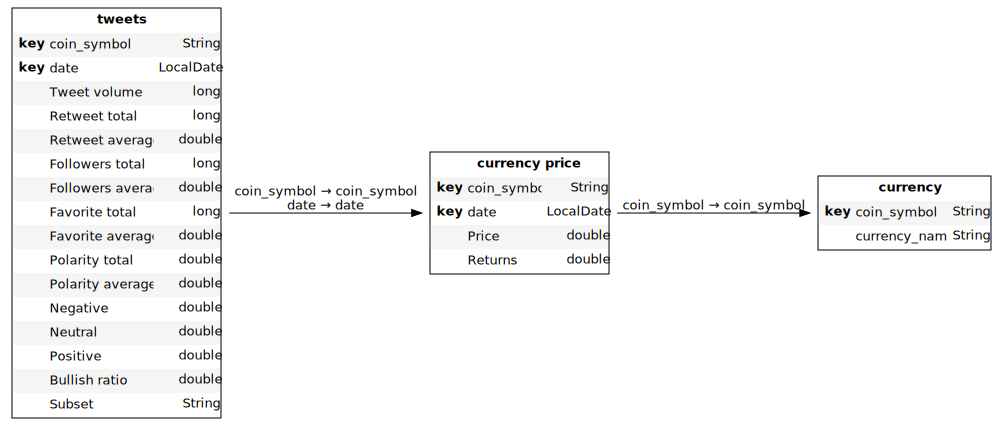

In [15]:
cube.schema

In [16]:
h = cube.hierarchies
l = cube.levels
m = cube.measures

### Hierarchies creation  

Let's create the hierarchies by specifying the columns from the stores directly in a list as shown below.  
Note that we can have multilevel hierarchies in the order listed in the list, as in the case of the `coin_symbol` amd `currency_name`.  \
Also, we have set the `Coin Symbol` hierarchy as a slicing hierarchy. This will allow us to view only 1 cryptocurrency at at time by default.

In [17]:
h["Coin Symbol"] = [tweets_table["coin_symbol"], currency_table["currency_name"]]
h["Coin Symbol"].dimension = "Cryptocurrency"
h["Coin Symbol"].slicing = True

h["Date"] = [tweets_table["date"]]
h["Date"].dimension = "Time-series"

# used for splitting training and test data
h["Subset"] = [tweets_table["Subset"]]

In [18]:
session.visualize("Multi-level hierarchies")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [19]:
h

{('Cryptocurrency', 'Coin Symbol'): <atoti.hierarchy.Hierarchy object at 0x000002344736A310>, ('tweets', 'Subset'): <atoti.hierarchy.Hierarchy object at 0x000002344736A0D0>, ('Time-series', 'Date'): <atoti.hierarchy.Hierarchy object at 0x000002344736A880>}

### Measure creations

In [20]:
m["Tweet volume"] = tt.agg.sum(tweets_table["Tweet volume"])
m["Retweet total"] = tt.agg.sum(tweets_table["Retweet total"])
m["Followers total"] = tt.agg.sum(tweets_table["Followers total"])
m["Favorite total"] = tt.agg.sum(tweets_table["Favorite total"])
m["Polarity total"] = tt.agg.sum(tweets_table["Polarity total"])
m["Negative"] = tt.agg.sum(tweets_table["Negative"])
m["Neutral"] = tt.agg.sum(tweets_table["Neutral"])
m["Positive"] = tt.agg.sum(tweets_table["Positive"])

In [21]:
m["Retweet average"] = tt.agg.mean(tweets_table["Retweet average"])
m["Followers average"] = tt.agg.mean(tweets_table["Followers average"])
m["Favorite average"] = tt.agg.mean(tweets_table["Favorite average"])
m["Polarity average"] = tt.agg.mean(tweets_table["Polarity average"])

m["Price"] = tt.agg.mean(price_table["Price"])
m["Returns"] = tt.agg.mean(price_table["Returns"])

### Bullish ratio
_Bullish ratio_ is similar to the [Bull/Bear ratio](https://www.investopedia.com/terms/b/bullbearratio.asp), where we take the number of positive sentiment over the number of negative sentiments:

#### $BullishRatio = \frac{PositiveTweets}{NegativeTweets}  $

The higher the _bullish ratio_ (greater than 1.0) implies greater public confidence in the price going up for the currency. 

In [22]:
m["Bullish ratio"] = m["Positive"] / m["Negative"]

We can see from the chart below that that was greater confidence in Ethereum (ETH) compared to Bitcoin (BTC) generally among the tweets that was collected.  
However, do note that the number of tweets collected for both currencies differ greatly as we can see in the chart that follows. Hence we cannot infer that ETH will have better growth than BTC.  
It should be considered as a feature that contributes to the trend of the time-series itself.

In [23]:
session.visualize("Bullish ratio for BTC and ETH")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [24]:
session.visualize("Tweet volumes for BTC and ETH")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

##### Organizing the measures

Since we have different type of measures, we can category them by storing them in different folders.

In [25]:
metrics_folder = "metrics"
m["Tweet volume"].folder = metrics_folder
m["Retweet total"].folder = metrics_folder
m["Followers total"].folder = metrics_folder
m["Favorite total"].folder = metrics_folder
m["Polarity total"].folder = metrics_folder
m["Negative"].folder = metrics_folder
m["Neutral"].folder = metrics_folder
m["Positive"].folder = metrics_folder
m["Retweet average"].folder = metrics_folder
m["Followers average"].folder = metrics_folder
m["Favorite average"].folder = metrics_folder
m["Polarity average"].folder = metrics_folder
m["Price"].folder = metrics_folder
m["Returns"].folder = metrics_folder
m["Bullish ratio"].folder = metrics_folder

#### Sorting by labels

We want the cryptocurrencies to appear in the order listed in the `coins` list defined earlier on. We can do so using the level `comparator`.

In [26]:
l["coin_symbol"].order = tt.CustomOrder(first_elements=coins)

When querying the cube, the result is now sorted by the `coin_symbol` by default.

In [27]:
session.visualize("Default slicing member ordering updated")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

# Exploring Time-series for forecasting

We are going to extract the time-series of different features for our analysis. We can do so by query the atoti datacube.  
Note that we are only going to select the train dataset. 

In [28]:
metrics_df = cube.query(
    m["Price"],
    m["Returns"],
    m["Tweet volume"],
    m["Retweet total"],
    m["Retweet average"],
    m["Followers total"],
    m["Followers average"],
    m["Favorite total"],
    m["Favorite average"],
    m["Polarity total"],
    m["Polarity average"],
    m["Bullish ratio"],
    levels=[l["coin_symbol"], l["date"]],
    filter=(l["Subset"] == "Train"),
)

metrics_df.shape

(3244, 12)

In [29]:
metrics_df.head()

Price     Returns  Tweet volume  Retweet total  \
coin_symbol date                                                               
BTC         2019-12-31  7240.428912 -153.600373          2332           1594   
            2020-01-01  7195.153895  -45.275017          2028           4858   
            2020-01-02  7193.754668   -1.399227          2355           1410   
            2020-01-03  6963.853354 -229.901314          2772           3166   
            2020-01-04  7300.346935  336.493581          2708           1660   

                        Retweet average  Followers total  Followers average  \
coin_symbol date                                                              
BTC         2019-12-31         0.683533         10696622        4586.887650   
            2020-01-01         2.395464          9453846        4661.659763   
            2020-01-02         0.598726         12082863        5130.727389   
            2020-01-03         1.142136         12813396        4622.437229   
            2020-01-04         0.612999         11182881        4129.572009   

                        Favorite total  Favorite average  Polarity total  \
coin_symbol date                                                           
BTC         2019-12-31            4512          1.934820       62.804530   
            2020-01-01            7258          3.578895       69.909621   
            2020-01-02            4512          1.915924       52.344366   
            2020-01-03            8755          3.158369       30.841316   
            2020-01-04            5007          1.848966      -24.496686   

                        Polarity average  Bullish ratio  
coin_symbol date                                         
BTC         2019-12-31          0.026932       1.339658  
            2020-01-01          0.034472       1.615385  
            2020-01-02          0.022227       1.313765  
            2020-01-03          0.011126       1.136298  
            2020-01-04         -0.009046       0.747604

Let's create a dataframe to capture the statistics we will be gathering from different tests. We will load it into atoti later on for a complete analysis.

In [30]:
data_stats = pd.DataFrame(
    columns=[
        "coin_symbol",
        "metric_name",
        "norm_stat",
        "norm_p",
        "kurtosis",
        "skewness",
        "lag_acf",
        "lag_pacf",
        "std",
        "durbin_watson",
    ]
)

## Time-series stationarity checking  

A [stationary process](https://en.wikipedia.org/wiki/Stationary_process) has the property that the mean, variance and autocorrelation structure do not change over time. Most time-series analysis is only applicable if the time-series is stationary, hence non-stationary time-series will be transformed to become stationary. There are [few ways to tranform a non-stationary time-series into a stationary time-series](https://www.aiproblog.com/index.php/2018/08/21/4-common-machine-learning-data-transforms-for-time-series-forecasting/) but we are just going to apply differencing on the series in this case.    

### 1. Visual checks by plotting
The most basic method to determine if the time-series is stationary is by plotting the data and visually assess the properties. Click on the URL below to view the plotting of the time-series in dashboard.

In [31]:
session.link(path="/#/dashboard/810")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### 2. Autocorrelation function (ACF) and Partial auto-correlation function (PACF)

[Autocorrelation](https://www.investopedia.com/terms/a/autocorrelation.asp) is the degree of similarity between a given time series and a lagged version of itself over successive time intervals. It can cause problems in conventional analyses (such as ordinary least squares regression) that assume independence of observations (based on [Gauss-Markov condition](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem)). With the presences of autocorrelation, we maybe underestimating the error variances, making confidence interval calculation etc invalid.  

[Partial autocorrelation](https://en.wikipedia.org/wiki/Partial_correlation) is the correlation between 2 observations in a time-series, after removing the effect of any correlations of any observations in between the 2 time points, i.e. the partial correlation at lag _(k+5)_ is the correlation that results after removing the effect of correlation in lag _(k+1)_ to lag _(k+4)_. We can use the PACF to determine how many past lags to include in the forecasting equation of the VAR model.  

For now, we can use the ACF plots to test for stationary data as __it will drop to zero relatively quickly for stationary data and conversely, decreases slowly for non-stationary data__.  

We will use the [`acf`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.acf.html) and [`pacf`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html) functions from [statsmodels](https://www.statsmodels.org/stable/index.html).

In [32]:
for coin in coins:
    coin_df = metrics_df.loc[[coin]]
    for metric_name in coin_df.columns:
        metric = coin_df[metric_name]

        # autocorrelation
        lag_acf = acf(metric, nlags=50, fft=True).tolist()
        lag_pacf = pacf(metric, nlags=50, method="ols").tolist()
        tmp_df = pd.DataFrame(
            data={
                "coin_symbol": coin,
                "metric_name": metric_name,
                "lag_acf": [lag_acf],
                "lag_pacf": [lag_pacf],
                "std": metric.std(),
            }
        )

        data_stats = pd.concat([data_stats, tmp_df])

data_stats.head()

,coin_symbol,metric_name,norm_stat,norm_p,kurtosis,skewness,lag_acf,lag_pacf,std,durbin_watson
0,BTC,Price,NaN,NaN,NaN,NaN,"[1.0, 0.976102682101795, 0.9537605753036547, 0...","[1.0, 0.9811039672291636, 0.03801215545499004,...",1.574675e+03,NaN
0,BTC,Returns,NaN,NaN,NaN,NaN,"[1.0, -0.04673687881492641, 0.0909598584659298...","[1.0, -0.04673755928304801, 0.0890023369260757...",3.046135e+02,NaN
0,BTC,Tweet volume,NaN,NaN,NaN,NaN,"[1.0, 0.9202680399465184, 0.8372197286477528, ...","[1.0, 0.925279104535465, -0.046042928791529825...",4.643504e+03,NaN
0,BTC,Retweet total,NaN,NaN,NaN,NaN,"[1.0, 0.9096293381540517, 0.810053729003923, 0...","[1.0, 0.9097076935407052, -0.09966284337289744...",4.809675e+06,NaN
0,BTC,Retweet average,NaN,NaN,NaN,NaN,"[1.0, 0.9191982159068977, 0.8243302471907452, ...","[1.0, 0.9198207312150228, -0.1283059947821329,...",2.801552e+02,NaN


For now, we see the values returned by `acf` and `pacf` being stored as a concatenated list and not plotted as per usual practice. We shall plot these values later on with atoti.

### Managing analysis across multiple time-series
While data scientists maybe used to plot the ACF and PACF with [Matplotlib](https://matplotlib.org/) or [seaborn](https://seaborn.pydata.org/) immediately, this may create a clutter on the notebook.   
This is especially so when we have 12 time-series that we are evaluating across 12 Cryptocurrencies.  

To better manage our analysis, let's load the data into the atoti datacube so that we can evaluate them by each coin later on.

##### Creating statistic data store for test results computed outside of atoti  

Instead of creating atoti table via `read_pandas`, we can also create the atoti table in advance with the necessary columns and data type.  
We can the use the various [table loading functions](https://docs.atoti.io/latest/lib/atoti/atoti.table.html#atoti.Table) to load data into the existing table.

In [33]:
stats_table = session.create_table(
    name="statistic",
    types={
        "coin_symbol": tt.type.STRING,
        "metric_name": tt.type.STRING,
        "norm_stat": tt.type.FLOAT,
        "norm_p": tt.type.FLOAT,
        "kurtosis": tt.type.FLOAT,
        "skewness": tt.type.FLOAT,
        "lag_acf": tt.type.FLOAT_ARRAY,
        "lag_pacf": tt.type.FLOAT_ARRAY,
        "std": tt.type.FLOAT,
        "durbin_watson": tt.type.FLOAT,
    },
    keys=["coin_symbol", "metric_name"],
)

stats_table.load_pandas(data_stats)
stats_table.head()

norm_stat  norm_p  kurtosis  skewness  \
coin_symbol metric_name                                               
BTC         Price                   NaN     NaN       NaN       NaN   
            Followers total         NaN     NaN       NaN       NaN   
BCH         Price                   NaN     NaN       NaN       NaN   
BSV         Polarity average        NaN     NaN       NaN       NaN   
LTC         Price                   NaN     NaN       NaN       NaN   

                                                                        lag_acf  \
coin_symbol metric_name                                                           
BTC         Price             [1.0, 0.9761027, 0.95376056, 0.92829037, 0.906...   
            Followers total   [1.0, 0.7581873, 0.5394558, 0.50076455, 0.4554...   
BCH         Price             [1.0, 0.9676745, 0.94120467, 0.9128811, 0.8857...   
BSV         Polarity average  [1.0, 0.4749774, 0.2281566, 0.26957244, 0.4138...   
LTC         Price             [1.0, 0.97225213, 0.94746786, 0.9170283, 0.890...   

                                                                       lag_pacf  \
coin_symbol metric_name                                                           
BTC         Price             [1.0, 0.98110396, 0.038012154, -0.09849078, 0....   
            Followers total   [1.0, 0.7626432, -0.07925651, 0.29566067, -0.0...   
BCH         Price             [1.0, 0.96892464, 0.07990939, -0.033035845, 0....   
BSV         Polarity average  [1.0, 0.47733557, 0.0067654834, 0.20965128, 0....   
LTC         Price             [1.0, 0.9723944, 0.048904408, -0.119283214, 0....   

                                       std  durbin_watson  
coin_symbol metric_name                                    
BTC         Price             1.574675e+03            NaN  
            Followers total   7.249456e+06            NaN  
BCH         Price             6.327665e+01            NaN  
BSV         Polarity average  6.513315e-02            NaN  
LTC         Price             1.079999e+01            NaN

In [34]:
tweets_table.join(stats_table)

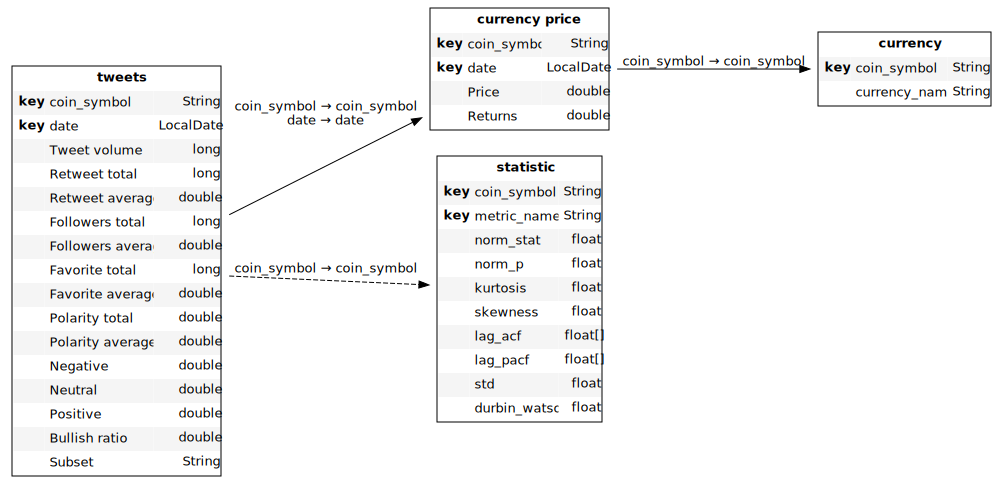

In [35]:
cube.schema

In [36]:
h["metric_name"].dimension = "Metrics"
h

{('Cryptocurrency', 'Coin Symbol'): <atoti.hierarchy.Hierarchy object at 0x0000023448FC8E80>, ('Metrics', 'metric_name'): <atoti.hierarchy.Hierarchy object at 0x0000023448F65310>, ('tweets', 'Subset'): <atoti.hierarchy.Hierarchy object at 0x0000023448F653A0>, ('Time-series', 'Date'): <atoti.hierarchy.Hierarchy object at 0x0000023448F65490>}

##### Creating measures for the statistics

We need to create the measures we are interested in as we are in manual mode and they won't be automatically created.

In [37]:
m["lag_acf"] = tt.agg.single_value(stats_table["lag_acf"])
m["lag_pacf"] = tt.agg.single_value(stats_table["lag_pacf"])
m["std"] = tt.agg.single_value(stats_table["std"])

# placeholder for later test data
m["norm_stat"] = tt.agg.single_value(stats_table["norm_stat"])
m["norm_p"] = tt.agg.single_value(stats_table["norm_p"])
m["kurtosis"] = tt.agg.single_value(stats_table["kurtosis"])
m["skewness"] = tt.agg.single_value(stats_table["skewness"])

Note that the `durbin_watson` value is only meaningful for the metrics, hence we will not proprogate its value beyond this level.  
At this point, there is no data loaded for this measure yet.

In [38]:
durbin_watson = tt.agg.single_value(stats_table["durbin_watson"])
m["durbin watson"] = tt.where((~l["metric_name"].isnull()), durbin_watson)

We can categorise and store the measures into folders.

In [39]:
stats_folder = "Statistics"
m["std"].folder = stats_folder
m["lag_acf"].folder = stats_folder
m["lag_pacf"].folder = stats_folder

In [40]:
session.visualize("Bit coin metrics statistics")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### Vectors into measures

`lag_acf` and `lag_pacf` are stored as vectors with values for 50 lags. In order to plot the acf and pacf, let's create a [parameter hierarchy](https://docs.atoti.io/0.4.3/lib/atoti.html?highlight=create_parameter_hierarchy#atoti.cube.Cube.create_parameter_hierarchy) called `Lags` to access each value in the vectors. 
The parameter hierarchy will consist of values ranging from 0 to 49, each corresponding to a point in the vector.  

In [41]:
cube.create_parameter_hierarchy_from_members(
    "Lags",
    list(range(0, 50)),
    index_measure_name="Lag Index",
)

In [42]:
h["Lags"].slicing = False

We can now access each value of the vector by creating a measure that uses the `index_measure` of the new parameter hierarchy as an index into the vector.

In [43]:
m["acf"] = m["lag_acf"][m["Lag Index"]]
m["acf"].formatter = "DOUBLE[#,###.0000]"

m["pacf"] = m["lag_pacf"][m["Lag Index"]]
m["pacf"].formatter = "DOUBLE[#,###.0000]"

Before plotting the ACF and PACF, let's compute the upper and lower confidence level.  
We set the critical value as [1.96](https://www.statisticshowto.com/probability-and-statistics/find-critical-values/#CommonCI) for 95% confidence level.  

In [44]:
m["Sample size"] = tt.total(tt.agg.count_distinct(tweets_table["date"]), h["Date"])

In [45]:
m["critical value"] = 1.96
m["Upper 95% confidence interval"] = m["critical value"] / tt.math.sqrt(
    m["Sample size"]
)
m["Lower 95% confidence interval"] = -m["critical value"] / tt.math.sqrt(
    m["Sample size"]
)

See the ACF and PACF for Bitcoin price time-series.  
There is a good positive correlation with lags up to 36 lags where `acf` cuts the upper confidence interval.  
After 1 lags, PACF cuts the upper confidence interval. In this case, the lag order for our auto-regression process is 1.

In [46]:
session.visualize("Auto-correlation for BTC price")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Comparing the ACF for `Price` and `Returns` below, we can see that the time-series for Price is non-stationary while Returns is stationary.

In [47]:
session.visualize("Auto-correlation for BTC Returns")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Making time-series stationary with ADF testing and differencing

With the above 2 methods, we visually determine if the time-series is stationary. However, to be able to run a systematic algorithm testing through the time-series of the difference cryptocurrencies, we can make use of the [augmented Dickey-Fuller test (ADF)](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to determine this. By testing the null hypothesis that a [unit root](https://www.statisticshowto.com/unit-root/) is present in the time-series, it implies a stochastic process that is non-stationary. By using ADF, we can recursively apply differencing on the time-series until no unit root is detected.  

Let's create some dataframe to store our transformed time-series and each differenced series.

In [48]:
metric_cols = metrics_df.reset_index().columns.to_list()
transformed_df = pd.DataFrame(columns=metric_cols).set_index(["coin_symbol", "date"])

metric_cols.append("order")
full_diff_df = pd.DataFrame(columns=metric_cols).set_index(
    ["coin_symbol", "date", "order"]
)

The `full_diff_df` stores the output from each differencing of the time-series. We will commit these series into the atoti cube as a scenario.  
`coin_df` stores the final stationary time-series which we will perform further analysis on.  

In [49]:
for coin in coins:
    coin_df = metrics_df.loc[[coin]].dropna()

    # reset dataframe
    full_diff_df = pd.DataFrame()

    for col in coin_df.columns:
        full_diff_df, coin_df[col] = utils.augmented_dickey_fuller_statistics(
            coin, col, coin_df[col], 0, full_diff_df
        )

    if len(full_diff_df) > 0:
        full_diff_df.reset_index(inplace=True)
        for diff_order in full_diff_df["order"].unique():
            scenario = full_diff_df.loc[full_diff_df["order"] == diff_order].copy()
            scenario.dropna(axis="columns", how="all", inplace=True)
            scenario["Subset"] = "Train"

            # Pending fix from https://github.com/activeviam/atoti/issues/3844
    #             price_table.scenarios[f"d{diff_order}"].load_pandas(
    #                 scenario.loc[
    #                     :, scenario.columns.isin(["coin_symbol", "date", "Price", "Return"])
    #                 ]
    #             )

    #             tweets_table.scenarios[f"d{diff_order}"].load_pandas(
    #                 scenario.drop(columns=["order", "Price", "Return"], errors="ignore")
    #             )

    coin_df.dropna(inplace=True)

    transformed_df = pd.concat([transformed_df, coin_df])

BTC Price p-value: 0.418365 There is unit root (Cannot reject null hypothesis) - Repeat differencing
BTC Tweet volume p-value: 0.774016 There is unit root (Cannot reject null hypothesis) - Repeat differencing
BTC Retweet total p-value: 0.595982 There is unit root (Cannot reject null hypothesis) - Repeat differencing
BTC Retweet average p-value: 0.279236 There is unit root (Cannot reject null hypothesis) - Repeat differencing
BTC Followers total p-value: 0.209442 There is unit root (Cannot reject null hypothesis) - Repeat differencing
BTC Followers average p-value: 0.626548 There is unit root (Cannot reject null hypothesis) - Repeat differencing
BTC Favorite total p-value: 0.077786 There is unit root (Cannot reject null hypothesis) - Repeat differencing
BTC Polarity total p-value: 0.182349 There is unit root (Cannot reject null hypothesis) - Repeat differencing
ETH Price p-value: 0.770218 There is unit root (Cannot reject null hypothesis) - Repeat differencing
ETH Tweet volume p-value: 

After the transformation by differencing, we should be able to see the difference in the plot as shown below (Base is the original plot, d1 implies differencing the data once, d2 implies differencing twice etc).  
We see that differencing the `Price` (non-stationary) will give us the `Returns` (stationary). Hence it is sufficient for us to perform Granger Causality check against `Returns` only.

In [50]:
# Pending fix from https://github.com/activeviam/atoti/issues/3844
# session.visualize("Non stationary Price")

In [51]:
session.visualize("Stationary Returns")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Refer to the "04 - Stationary vs ACF" dashboard from the below URL to see how the time-series have changed. Use the Content editor to change the filter on the `coin_symbol` to view the time-series for a different currency.

In [52]:
session.link(path="/#/dashboard/010")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

<img src="https://data.atoti.io/notebooks/twitter/img/stationary_checking.gif" alt="Stationary check" width="800"/>

## Granger Causality Testing

We will apply [Granger causality testing](https://en.wikipedia.org/wiki/Granger_causality) on the time-series of the different metrics against the `Returns` time-series to see if the metric can be used to forecast the returns.  

By using [Statsmodel's `grangercausalitytests`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html), our null hypothesis is as follows:  
- The time-series in the second column (our metrics) does NOT Granger cause the time series in the first column (our returns)  

We will capture the `p-value`, `F-value`/`Chi2`, `df_denom`, `df_num` from the test and load it into the atoti cube after to evaluate the hypothese.  
Similar to the ACF and PACF, we are going to compute the test for __50 lags__.

In [53]:
grangercausalitytests_df = pd.DataFrame(
    columns=[
        "coin_symbol",
        "x",
        "y",
    ]
)


def grangers_causality_matrix(coin, train_data, maxlag, verbose=False):
    global grangercausalitytests_df
    columns = train_data.columns

    r = "Returns"
    scal = StandardScaler()
    df_scaled = pd.DataFrame(
        scal.fit_transform(train_data.values),
        columns=train_data.columns,
        index=train_data.index,
    )

    for c in columns:
        if c not in ["Price", "Returns"]:
            if verbose:
                print(f"{coin} ============= Returns against {c}")

            X_train = df_scaled[[r, c]]

            gc_test_result = grangercausalitytests(
                X_train, maxlag=maxlag, verbose=False
            )
            if verbose:
                print("********************************************")
                print(gc_test_result)

            # transform test_result into stats for x causes y
            grangercausalitytests_df = utils.transform_gc_date(
                coin, gc_test_result, c, r, maxlag, grangercausalitytests_df, verbose
            )

In [54]:
for coin in coins:
    coin_train_data = transformed_df.loc[
        (transformed_df.index.get_level_values("coin_symbol") == coin)
    ]

    grangers_causality_matrix(coin, coin_train_data.copy(), 50, verbose=False)

In [55]:
grangercausalitytests_df.loc[
    (grangercausalitytests_df["coin_symbol"] == "BTC")
    & (grangercausalitytests_df["Test name"] == "params_ftest")
].head()

,coin_symbol,x,y,Test name,p-value,F,df_denom,df_num,chi2,df
0,BTC,Tweet volume,Returns,params_ftest,"[0.8611, 0.8303, 0.9637, 0.9889, 0.935, 0.9113...","[0.0307, 0.1861, 0.0933, 0.0781, 0.2589, 0.346...","[257.0, 254.0, 251.0, 248.0, 245.0, 242.0, 239...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",NaN,NaN
0,BTC,Retweet total,Returns,params_ftest,"[0.8699, 0.9784, 0.9979, 0.9898, 0.9974, 0.999...","[0.0269, 0.0218, 0.0132, 0.0747, 0.0621, 0.062...","[257.0, 254.0, 251.0, 248.0, 245.0, 242.0, 239...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",NaN,NaN
0,BTC,Retweet average,Returns,params_ftest,"[0.9042, 0.9147, 0.9767, 0.957, 0.9797, 0.9902...","[0.0145, 0.0892, 0.0683, 0.1629, 0.1506, 0.143...","[257.0, 254.0, 251.0, 248.0, 245.0, 242.0, 239...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",NaN,NaN
0,BTC,Followers total,Returns,params_ftest,"[0.339, 0.592, 0.7429, 0.9178, 0.6049, 0.6527,...","[0.9175, 0.5253, 0.4142, 0.2361, 0.7255, 0.696...","[257.0, 254.0, 251.0, 248.0, 245.0, 242.0, 239...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",NaN,NaN
0,BTC,Followers average,Returns,params_ftest,"[0.133, 0.1049, 0.2296, 0.285, 0.0823, 0.14, 0...","[2.2713, 2.2753, 1.447, 1.2633, 1.9795, 1.6277...","[257.0, 254.0, 251.0, 248.0, 245.0, 242.0, 239...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",NaN,NaN


#### Loading Granger Causality results into atoti cube

In [56]:
granger_causality_table = session.read_pandas(
    grangercausalitytests_df,
    keys=["coin_symbol", "Test name", "x", "y"],
    table_name="Granger Causality",
)

In [57]:
tweets_table.join(
    granger_causality_table,
    tweets_table["coin_symbol"] == granger_causality_table["coin_symbol"],
)

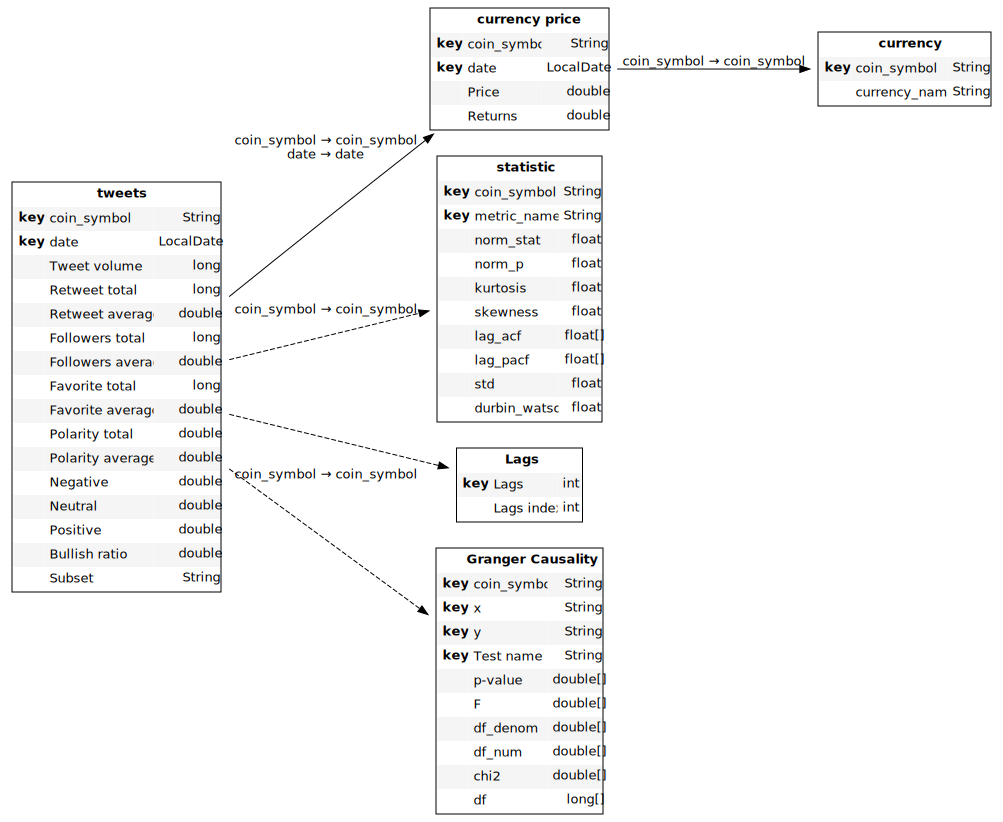

In [58]:
cube.schema

In [59]:
h["Test name"] = [granger_causality_table["Test name"]]
h["Test name"].slicing = True

In [60]:
m["v_F"] = tt.where(
    ~l["coin_symbol"].isnull(), tt.agg.single_value(granger_causality_table["F"])
)

m["v_chi2"] = tt.where(
    ~l["coin_symbol"].isnull(), tt.agg.single_value(granger_causality_table["chi2"])
)

m["v_p_value"] = tt.where(
    ~l["coin_symbol"].isnull(), tt.agg.single_value(granger_causality_table["p-value"])
)

m["v_df"] = tt.where(
    ~l["coin_symbol"].isnull(), tt.agg.single_value(granger_causality_table["df"])
)

m["v_df_denom"] = tt.where(
    ~l["coin_symbol"].isnull(), tt.agg.single_value(granger_causality_table["df_denom"])
)

m["v_df_num"] = tt.where(
    ~l["coin_symbol"].isnull(), tt.agg.single_value(granger_causality_table["df_num"])
)

Accessing the vectors by using the index of the parameter hierarchy - `Lag Index`.

In [61]:
m["GCT F"] = m["v_F"][m["Lag Index"]]
m["GCT chi2"] = m["v_chi2"][m["Lag Index"]]
m["GCT p-value"] = m["v_p_value"][m["Lag Index"]]
m["GCT df"] = m["v_df"][m["Lag Index"]]
m["GCT df_denom"] = m["v_df_denom"][m["Lag Index"]]
m["GCT df_num"] = m["v_df_num"][m["Lag Index"]]

m["GCT F"].formatter = "DOUBLE[#,###.000000]"
m["GCT chi2"].formatter = "DOUBLE[#,###.000000]"
m["GCT p-value"].formatter = "DOUBLE[#,###.000000]"

### Creating measure for level of significant

We have created the level of significant as a measure `alpha` using [`create_parameter_simulation`](https://docs.atoti.io/latest/lib/atoti.cube.html#atoti.cube.Cube.create_parameter_simulation). We can use this measure to perform simulation with different alpha values later on.

In [62]:
# level of significance
significant_simulation = cube.create_parameter_simulation(
    "Significance simulation",
    measures={"alpha": 0.05},
    base_scenario_name="0.05",
)

From the below `p-value` for Bitcoin, we can rejected the null hypothesis at 95% confidence level:
- Favorite average
- Followers average 
- Tweet volume

In [63]:
session.visualize("Granger causality test Params_ftest p-value for Bitcoin")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We are only interested in the features that may Granger cause `Returns`. Instead of visually determining the features that had null hypothesis rejected, we shall create a simple measure that will return a value 1 for each lag when it happens.

In [64]:
m["Granger causality"] = tt.agg.sum(
    tt.where(m["GCT p-value"] < m["alpha"], 1, None), scope=tt.OriginScope(l["Lags"])
)

In this use case, we will select the feature so long as one of the lags has the null hypothesis rejected, i.e. feature may Granger cause Returns.  
We could have more stringent selection criterias implemented if necessary.

In [65]:
session.visualize("Number of lags with null hypothesis rejected for params_ftest")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Launch the below dashboard to check the Granger causality results for different cryptocurrencies and how they vary for different tests.

In [66]:
session.link(path="/#/dashboard/70f")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## Prediction using Vector Autoregression model (VAR)

In this notebook, we will be using [Statsmodel VAR](https://www.statsmodels.org/0.6.1/vector_ar.html) to forecast the `Returns`.  

Before we proceed with the forecast, there are some data that we are going to capture from the model and load into atoti:
- forecast value 
- residuals
- statistics about the accuracy of the forecast
- normaltest results (stats, p-value) as well as kurtosis and skewness to test the distribution of the residual
- Durbin-watson testing on the residual 

Let's prepare the structure for these data.

#### Residual store

In [67]:
residual_table = session.create_table(
    name="residual",
    keys=["coin_symbol", "date"],
    types={
        "coin_symbol": tt.type.STRING,
        "date": tt.type.LOCAL_DATE,
        "Returns residual": tt.type.FLOAT,
    },
)
residual_table.head()

,,Returns residual
coin_symbol,date,


In [68]:
forecast_table = session.create_table(
    name="Forecast accuracy",
    keys=["coin_symbol"],
    types={
        "coin_symbol": tt.type.STRING,
        "lag_order": tt.type.INT,
        "Observations": tt.type.INT,
        "mape": tt.type.FLOAT,
        "me": tt.type.FLOAT,
        "mae": tt.type.FLOAT,
        "mpe": tt.type.FLOAT,
        "rmse": tt.type.FLOAT,
        "corr": tt.type.FLOAT,
        "minmax": tt.type.FLOAT,
    },
    default_values={
        "lag_order": 0,
        "Observations": 0,
        "mape": 0.0,
        "me": 0.0,
        "mae": 0.0,
        "mpe": 0.0,
        "rmse": 0.0,
        "corr": 0.0,
        "minmax": 0.0,
    },
)

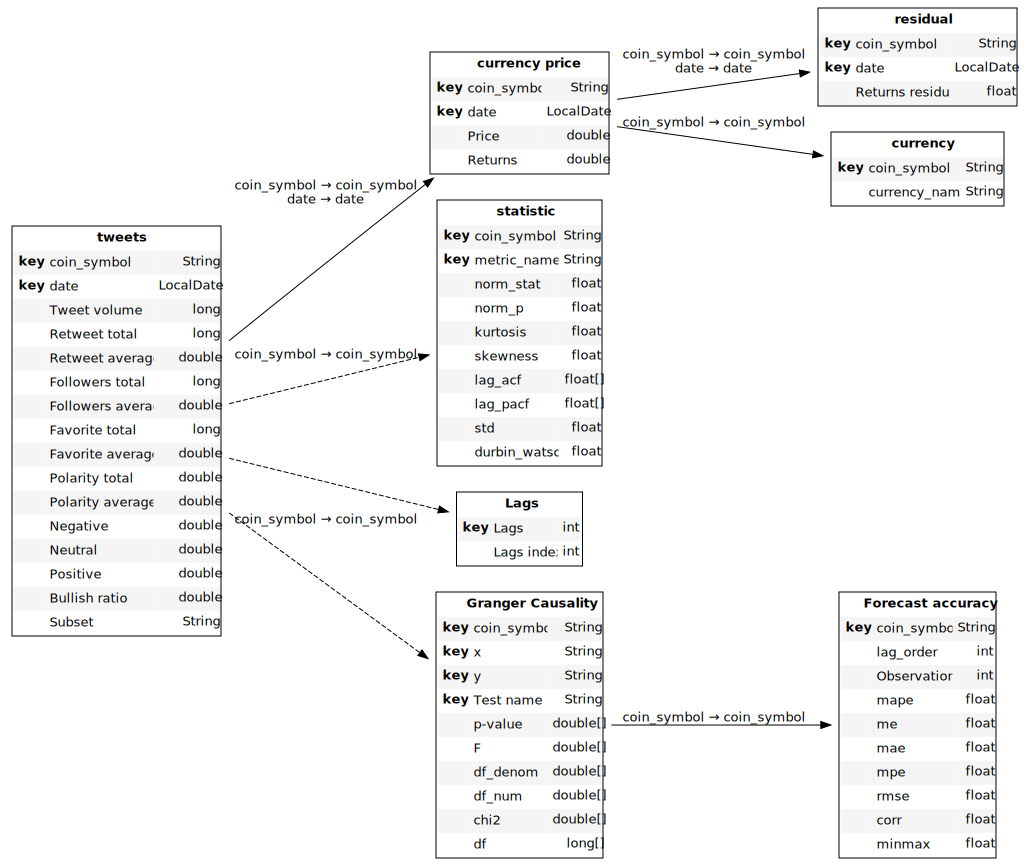

In [69]:
price_table.join(residual_table)
granger_causality_table.join(forecast_table)
cube.schema

In [70]:
m["Returns residual"] = tt.agg.single_value(residual_table["Returns residual"])
m["Returns residual"].formatter = "DOUBLE[#,###.0000]"

In [71]:
stats_name = forecast_table.columns
stats_name.remove("coin_symbol")
stats_name

['lag_order',
 'Observations',
 'mape',
 'me',
 'mae',
 'mpe',
 'rmse',
 'corr',
 'minmax']

In [72]:
for name in stats_name:
    m[name] = tt.agg.single_value(forecast_table[name])

    m[name].folder = "Statistics"
    m[name].formatter = (
        "DOUBLE[#,###]"
        if name in ["lag_order", "Observations"]
        else "DOUBLE[#,###.0000]"
    )

### Run forecasting and store parameters

We are now ready to run our forecasting.  

We shall use the metrics that may Granger cause the `Returns` as features to the VAR, so let's extract this from the atoti cube.  
Let's consider the output from the `params_ftest`. __Notice below, atoti conveniently returns only those features with a `Granger causality` value.__

In [73]:
features_metrics = cube.query(
    m["Granger causality"],
    levels=[l["coin_symbol"], l["x"]],
    filter=l["Test name"] == "params_ftest",
).reset_index()
features_metrics.head()

,coin_symbol,x,Granger causality
0,BTC,Favorite average,1
1,BTC,Followers average,11
2,BTC,Tweet volume,19
3,ETH,Followers average,6
4,ETH,Followers total,11


Earlier, we set the number of observations based on the number of days we are forecasting, i.e. 7 days, as the test data. However, the actual number of days that will be predicted depends on the lag order returned by the model as we will see later on.  
We will need the test data to compute the forecast accuracy statistics. 

Again, note that we are loading the data into atoti cube as scenarios instead of printing them in the notebook.

In [74]:
def feature_forecast(scenario_name, features, data, verbose=False):
    global coins

    for coin in coins:
        # obtain the features that may Granger cause returns
        metrics_col = features.loc[features["coin_symbol"] == coin]["x"].to_list()
        metrics_col = ["Returns"] + metrics_col

        actual_df = cube.query(
            m["Returns"],
            levels=[l["coin_symbol"], l["date"]],
            filter=(l["Subset"] == "Test") & (l["coin_symbol"] == coin),
        )

        if len(metrics_col) == 1:
            print(coin, "=========== No features Granger cause returns")
            actual_df["Returns"] = np.nan
            price_table.scenarios[scenario_name].load_pandas(actual_df)

        else:
            print(
                f"Forecasting {coin} returns based on features",
                features.loc[features["coin_symbol"] == coin]["x"].to_list(),
            )

            train_data = data.loc[
                (transformed_df.index.get_level_values("coin_symbol") == coin)
            ][metrics_col]

            train_data = train_data.reset_index(["coin_symbol"], drop=True)

            nobs = 7
            df_residual, ds, accuracy_prod, df_forecast = utils.var_forecast(
                coin,
                data_stats.copy(),
                train_data.copy(),
                actual_df,
                nobs,
                verbose=verbose,
            )

            accuracy_prod.reset_index(inplace=True)
            accuracy_prod.rename(columns={"index": "coin_symbol"}, inplace=True)

            if df_forecast is not None:
                price_table.scenarios[scenario_name].load_pandas(df_forecast)
                residual_table.scenarios[scenario_name].load_pandas(df_residual)
                stats_table.scenarios[scenario_name].load_pandas(ds)
                forecast_table.scenarios[scenario_name].load_pandas(accuracy_prod)

In [75]:
feature_forecast("forecast (0.05)", features_metrics, transformed_df, verbose=False)

Forecasting BTC returns based on features ['Favorite average', 'Followers average', 'Tweet volume']
Forecasting ETH returns based on features ['Followers average', 'Followers total', 'Retweet average', 'Retweet total', 'Tweet volume']
Forecasting USDT returns based on features ['Favorite average', 'Favorite total', 'Followers average']
Forecasting XRP returns based on features ['Favorite average', 'Favorite total']
Forecasting BCH returns based on features ['Bullish ratio', 'Polarity total']
Forecasting ADA returns based on features ['Bullish ratio', 'Favorite average', 'Favorite total', 'Followers average', 'Followers total', 'Polarity total', 'Retweet total', 'Tweet volume']
Forecasting BSV returns based on features ['Favorite total', 'Followers total', 'Polarity total', 'Retweet total', 'Tweet volume']
Forecasting LTC returns based on features ['Bullish ratio', 'Polarity average', 'Polarity total', 'Tweet volume']
Forecasting LINK returns based on features ['Favorite total', 'Follow

C:\Users\hfy\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-_Jk8WYk--py3.9\lib\site-packages\numpy\lib\function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\hfy\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-_Jk8WYk--py3.9\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\hfy\AppData\Local\pypoetry\Cache\virtualenvs\notebooks-_Jk8WYk--py3.9\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [76]:
session.visualize("Cryptocurrency forecast for BTC")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Notice that we didn't de-differenciate the returns? That's because the returns time-series were stationary and no differencing were applied.  
Refer to the stationary dashboard below to confirm this.

In [77]:
# Pending https://github.com/activeviam/atoti/issues/3844
# session.link(path="/#/dashboard/010")

A few observations for the above forecast that uses the features `Favorite average`, `Followers average`, `Tweet volume`:
- the forecasted values are nowhere near the actual values except for the last 2 days (there is a chance that the number of observations observed is less than 7 days) 
- we can spot 2 days with the correct trend

Let's create some measures for us to how accurate the model forecast the trend, rather than the values.

In [78]:
m["Prev day returns"] = tt.date_shift(
    m["Returns"], h["Date"], offset="-P1D", method="exact"
)
m["Trend"] = tt.where(
    (m["Returns"] - m["Prev day returns"]) < 0,
    -1,
    tt.where((m["Returns"] - m["Prev day returns"]) > 0, 1, 0),
)
m["Trend Sign"] = tt.where(
    (m["Returns"] - m["Prev day returns"]) < 0,
    "📉",
    tt.where((m["Returns"] - m["Prev day returns"]) > 0, "📈", "➡"),
)

The greyed out cells are not being forecasted as the lag order returned by model is less than 7 days.

In [79]:
# to compare the days against the number of observations
m["row_number"] = tt.rank(
    tt.agg.sum(m["contributors.COUNT"], scope=tt.CumulativeScope(level=l["date"])),
    h["Date"],
    apply_filters=True,
)

In [80]:
session.visualize("Trend analysis across forcast")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## Distribution check on the residual

We run the SciPy `normaltest` on the residual from the VAR model (Refer to var_forecast#213 in [utils.py](_util/utils.py)). If p-value is less than or equal to 0.05 (at 95% confidence level), we will reject the null hypothesis below.
- Null hypothesis: Residuals are normally distributed
- Alternative hypothesis: Residuals are NOT normally distributed

For this, we create a measure for the confidence level and we define a measure `Distribution type` that will show _Gaussian_ if the p-value (`m[norm_p]`) is greater than the confidence level. 

In [81]:
m["Gaussian confidence"] = 0.05
m["Distribution type"] = tt.where(
    ~m["norm_p"].isnull(),
    tt.where((m["norm_p"] < m["Gaussian confidence"]), "Non-Gaussian", "Gaussian"),
)

Also, we obtained the kurtosis and skewness of the residuals. Based on [Fisher's definition of kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html), 0 is returned if all values are equal. Kurtosis value of less than -1 shows that the distribution is too flat while a value greater than 1 is too peaked.  
Skewness value between -0.5 and 0.5 shows that data are pretty symmetrical. Values between -1 and -0.5, or between 0.5 and 1, shows that data are moderately skewed. Otherwise, the data are highly skewed.  

In [82]:
session.visualize("Distribution check for Returns at 95% confidence level")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Durbin-Watson test
We run the [Durbin-Watson statistics](https://www.investopedia.com/terms/d/durbin-watson-statistic.asp) on the fitted value from the VAR mode. The Durbin-Watson statistics will detect the autocorrelation in the residual (difference between the observed value and the mean value that the model predicts for that observation) from the VAR. It can help to predict the movement of the observation based on historical data. __Positive correlation__ here implies that if the value __increased yesterday__, it would most likely __increase today__ as well. __Negative correlation__ implies that if the value __increased yesterday__, it would most likely __decrease today__.  

For our testing, we are going to assume that there is no auto-correlation for a value between the range 1.5 to 2.5.

In [83]:
session.visualize("Durbin-watson check")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [84]:
session.visualize("Forecast accuracy")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

The distributions on the residuals for all the Cryptocurrencies are non-Gaussian but all the features shown no auto-correlation.  
The model could be tuned better.  

Some factors that could have affected our analysis:
- Tweet volume: we have more Tweets collected after July 2020 compared to the previous months
- Tweets contributed by bots 
- Non-related topics that are tagged inaccurately to the Cryptocurrencies' tag
- Better tuning of Sentiment analysis

In [85]:
session.visualize("Tweet volume by cryptocurrency")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Access page 1 of the below dashboard to see the forecast for each cryptocurrency.

In [86]:
session.link(path="/#/dashboard/332")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

From the dashboard, the trend forecasting accuracy for ETH with the features ['Followers average', 'Followers total', 'Retweet average', 'Retweet total', 'Tweet volume'] was pretty close, with 4 out of 3 days predicted correctly. We'll leave you to decide if it makes any sense to have both `Retweet total` and `Retweet average` as features at the same time.    

The below page is an interactive dashboard in the sense you can click on a line from the chart to view its corresponding data in the rest of the widgets.
<img src="https://data.atoti.io/notebooks/twitter/img/forecast_eth_95.png" alt="Stationary check" width="800"/>

### What If the level of significant for the Granger Causality test changes?  

By changing the level of significant affects the features that are being selected for the VAR model as the basis for rejecting the null hypothesis changes.  
Previously, we have created the parameter measure `m["alpha"]` that is defaulted to 0.05 (initial forecast at 95% confidence level). 

Now we can see how the features are changed by changing the level of significant in different scenarios.

Let's try rejecting the null hypothesis for Granger Causality test at 90% and 99% confidence level in the scenario "0.1" and "0.01" below.

In [87]:
significant_simulation += ("0.01", 0.01)
significant_simulation += ("0.1", 0.1)

We will re-query the cube for the new set of features for these 2 scenarios:

In [88]:
features_metrics = cube.query(
    m["Granger causality"],
    levels=[l["Significance simulation"], l["coin_symbol"], l["x"]],
    filter=(l["Test name"] == "params_ftest")
    & (l["Significance simulation"].isin("0.01", "0.1")),
).reset_index()
features_metrics.head()

,Significance simulation,coin_symbol,x,Granger causality
0,0.01,ETH,Retweet average,17
1,0.01,ETH,Retweet total,11
2,0.01,ETH,Tweet volume,16
3,0.01,USDT,Favorite average,35
4,0.01,USDT,Favorite total,1


We will re-run the forecast for the cryptocurrencies for each confidence level and label them with a different scenario name based on the alpha value.

In [89]:
for alpha in features_metrics["Significance simulation"].unique():
    print("************************************************************")
    print(f"Forecasting at Granger Causality Test at significant level {alpha}")
    f = features_metrics.loc[features_metrics["Significance simulation"] == alpha]
    feature_forecast(f"forecast ({alpha})", f, transformed_df)

************************************************************
Forecasting at Granger Causality Test at significant level 0.01
BTC =========== No features Granger cause returns
Forecasting ETH returns based on features ['Retweet average', 'Retweet total', 'Tweet volume']
Forecasting USDT returns based on features ['Favorite average', 'Favorite total', 'Followers average']
Forecasting XRP returns based on features ['Favorite average', 'Favorite total']
Forecasting BCH returns based on features ['Bullish ratio', 'Polarity total']
Forecasting ADA returns based on features ['Bullish ratio', 'Retweet total']
Forecasting BSV returns based on features ['Favorite total', 'Followers total', 'Polarity total']
Forecasting LTC returns based on features ['Polarity total', 'Tweet volume']
Forecasting LINK returns based on features ['Favorite total', 'Followers total', 'Polarity total', 'Retweet average', 'Retweet total', 'Tweet volume']
Forecasting BNB returns based on features ['Bullish ratio', 'Pola

In [90]:
session.visualize("Total accuracy score over the number of forecasts")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

We can see that there are a few cryptocurrencies that have more than 50% correct prediction and it seems that Grangercausality at 90% have a pretty good trend prediction.  
However the prediction at best is approximately 57%. Let's see the features that attribute to the forecast for those with more than 50% correctly forecasted.

In [91]:
session.visualize(
    "Features used in forecasting cryptocurrencies with more than 50% accuracy"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Now access page 2 of the Forecast dashboard to dive into the details for each cryptocurrency.

In [92]:
session.link(path="/#/dashboard/332")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

What is surprising is that for BCH, we have more than 50% correct trend prediction for all 3 scenarios.   
While Tweet sentiment (polarity) may not necessary be able to forecast all the cryptocurrency, in this case, it is however one of the contributing features that may Granger cause and therefore forecast BCH.

<img src="https://data.atoti.io/notebooks/twitter/img/BCH_forecast.png" alt="Stationary check" width="900"/>  


  
<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=twitter" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="atoti" /></a></div>